**IMPORT REQUIRED LIBRARIES**

In [50]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**READ THE DATASET**

In [37]:
df = pd.read_csv('/content/spam.csv', delimiter=',',encoding='latin-1') 
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


**PRE-PROCESSING THE DATA**

In [38]:
useful_content=df[['v1','v2']]
useful_content.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [42]:
useful_content.shape
useful_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of ham and spam messages')

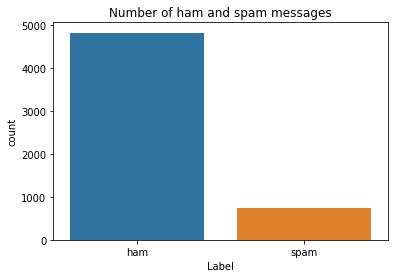

In [43]:
sns.countplot(useful_content.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [51]:
ps=PorterStemmer()
message=[]
for i in range(0,5572):
  msg=useful_content['v2'][i]
  msg=re.sub('[^a-zA-Z]',' ',msg)
  msg=msg.lower()
  msg=msg.split(' ')
  msg = [ps.stem(word) for word in msg if word not in set(stopwords.words('english'))]
  msg=' '.join(msg)
  message.append(msg)

message[:6]

['go jurong point  crazi   avail bugi n great world la e buffet    cine got amor wat   ',
 'ok lar    joke wif u oni   ',
 'free entri   wkli comp win fa cup final tkt   st may       text fa       receiv entri question std txt rate c appli             ',
 'u dun say earli hor    u c alreadi say   ',
 'nah think goe usf  live around though',
 'freemsg hey darl   week word back  like fun still  tb ok  xxx std chg send         rcv']

In [59]:
X = message
Y = useful_content.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

**SPLIT INTO TRAIN AND TEST DATASET**

In [60]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [61]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

**CREATING MODEL & ADDING LAYERS**

In [64]:
inputs = Input(name='inputs',shape=[max_len])
layer = Embedding(max_words,50,input_length=max_len)(inputs)
layer = LSTM(64)(layer)
layer = Dense(256,name='FC1')(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(1,name='out_layer')(layer)
layer = Activation('sigmoid')(layer)
model = Model(inputs=inputs,outputs=layer)

**COMPILE THE MODEL**

In [65]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

**FIT THE MODEL**

In [84]:
m =model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.00001)])

Epoch 1/10
30/30 [==============================] - 9s 300ms/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 0.1171 - val_accuracy: 0.9768
Epoch 2/10
30/30 [==============================] - 8s 254ms/step - loss: 0.0055 - accuracy: 0.9984 - val_loss: 0.1164 - val_accuracy: 0.9778


**SAVE THE MODEL**

In [91]:
model.save('Sms_spam_classifier.h5')

**TEST THE MODEL**

In [97]:
metrics = pd.DataFrame(m.history)
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs(var1, var2, string):
  metrics[[var1, var2]].plot()
  plt.title('Training and Validation ' + string)
  plt.xlabel ('Number of epochs')
  plt.ylabel(string)
  plt.legend([var1, var2])

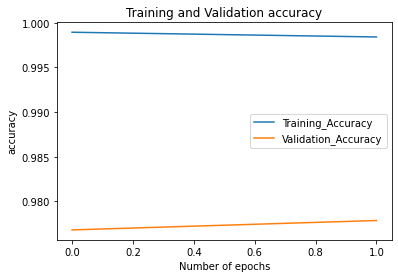

In [98]:
plot_graphs('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

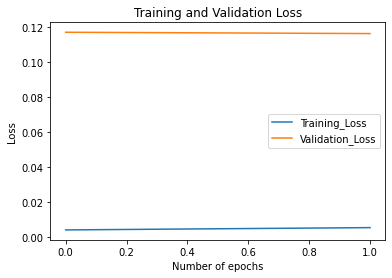

In [100]:
plot_graphs('Training_Loss','Validation_Loss','Loss')

In [87]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [88]:
accr = model.evaluate(test_sequences_matrix,Y_test)

27/27 [==============================] - 1s 21ms/step - loss: 0.1472 - accuracy: 0.9821


In [89]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.147
  Accuracy: 0.982
